In [9]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt




In [10]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2


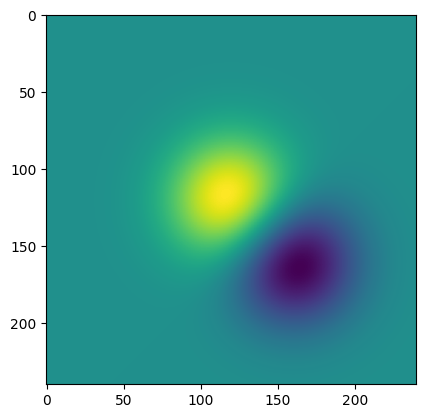

In [11]:
plt.imshow(Z)

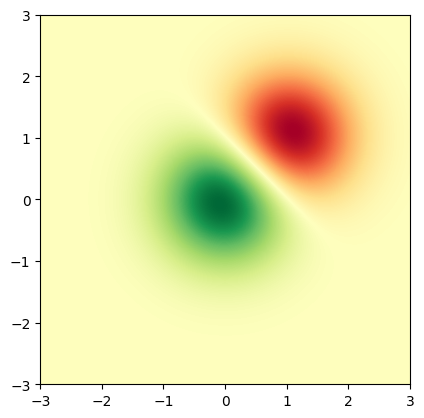

In [16]:

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-3, 3, -3, 3],
               vmax=abs(Z).max(), vmin=-abs(Z).max())

plt.show()


Text(0.5, 1.0, 'rainbow')

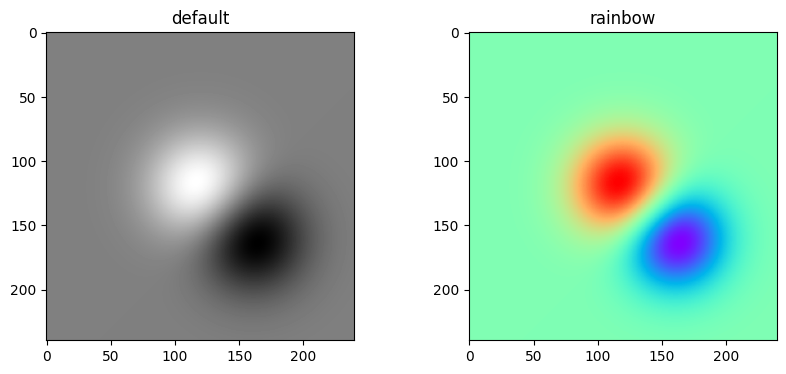

In [32]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(Z)
plt.title('default')

plt.subplot(1, 2, 2)
plt.imshow(Z,cmap=cm.rainbow)
plt.title('rainbow')


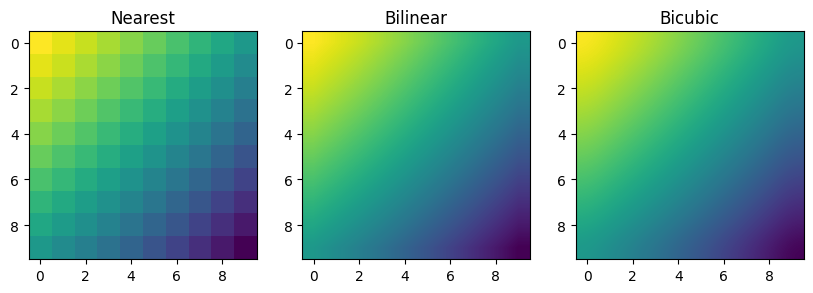

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for ax, interp in zip(axs, ['nearest', 'bilinear', 'bicubic']):
    ax.imshow(Z[125:135,125:135], interpolation=interp)
    ax.set_title(interp.capitalize())


plt.show()

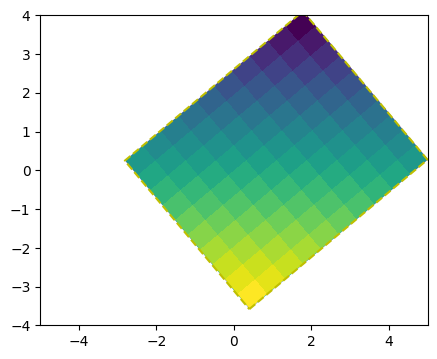

In [6]:
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(Z[125:135,125:135], interpolation='none',
                   origin='lower',
                   extent=[-2, 4, -3, 2], clip_on=True)

trans_data = mtransforms.Affine2D().rotate_deg(40) + ax.transData
im.set_transform(trans_data)

# display intended extent of the image
x1, x2, y1, y2 = im.get_extent()
ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], "y--",
            transform=trans_data)
ax.set_xlim(-5, 5)
ax.set_ylim(-4, 4)

plt.show()

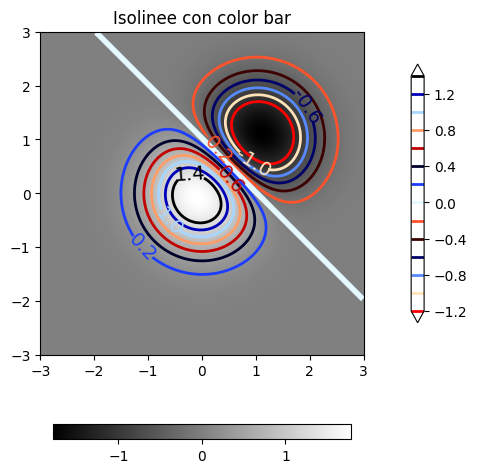

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
               cmap=cm.gray, extent=(-3, 3, -3, 3))
levels = np.arange(-1.2, 1.6, 0.2)
CS = ax.contour(Z, levels, origin='lower', cmap='flag', extend='both',
                linewidths=2, extent=(-3, 3, -3,3))

# Thicken the zero contour.
zc = CS.collections[6]
plt.setp(zc, linewidth=4)

ax.clabel(CS, levels[1::2],  # label every second level
          inline=True, fmt='%1.1f', fontsize=14)

# make a colorbar for the contour lines
CB = fig.colorbar(CS, shrink=0.8)

ax.set_title('Isolinee con color bar')

# We can still add a colorbar for the image, too.
CBI = fig.colorbar(im, orientation='horizontal', shrink=0.8)

# This makes the original colorbar look a bit out of place,
# so let's improve its position.

l, b, w, h = ax.get_position().bounds
ll, bb, ww, hh = CB.ax.get_position().bounds
CB.ax.set_position([ll, b + 0.1*h, ww, h*0.8])

plt.show()


Windowing


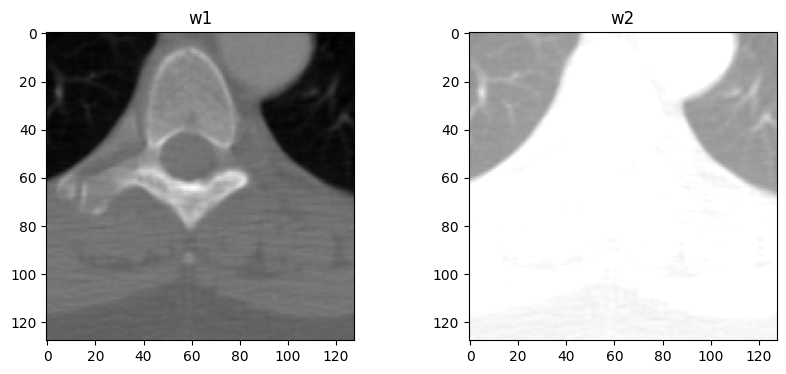

In [53]:
from pydicom import dcmread
from pydicom.data import get_testdata_file


fpath = get_testdata_file('CT_small.dcm')
ds = dcmread(fpath)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
plt.title('w1')

plt.subplot(1, 2, 2)
plt.imshow(ds.pixel_array, clim=(-1000,1000), cmap=plt.cm.gray)
plt.title('w2')



plt.show()


In [37]:
import os
PathDicom = "AorticCT/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [38]:
import pydicom
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [39]:
print(ConstPixelSpacing)

(0.742188, 0.742188, 2.5)


In [40]:
print(ConstPixelDims)

(512, 512, 200)


In [41]:
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [42]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

In [43]:
ds['WindowWidth']

(0028, 1051) Window Width                        DS: '400.0'

In [44]:
ds['WindowCenter']

(0028, 1050) Window Center                       DS: '80.0'

In [45]:
ds['RescaleIntercept']

(0028, 1052) Rescale Intercept                   DS: '-1024.0'

The correct windowing of the numerical value should be (-RI+wc-ww ,-RI+wc+ww)

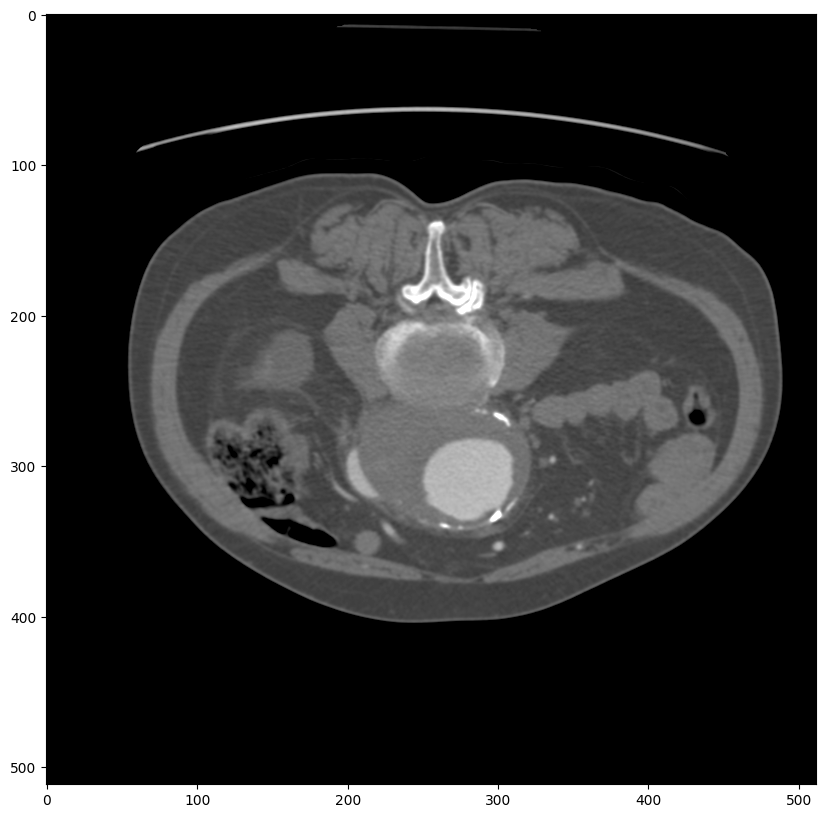

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.set_cmap(plt.gray())
ax.imshow(np.flipud(ArrayDicom[:, :, 100]), clim=(1024+80-400,1024+80+400), interpolation='bicubic')


Exercises: 
1) Slice an image on a plane perpendicular to this section in the central part
2) display with matplotlib and overlay contour computed at threshold 200 (or others)
3) Select correct windowing according to DICOM data
4) Change colormap to Viridis